In [1]:
import intake
cat = intake.open_catalog("../catalog.yaml")

In [2]:
run = cat.FESOM["tco2559-ng5"]

In [3]:
data = run.original_3d.to_dask()
grid = run.node_grid.to_dask()

In [4]:
import numpy as np
from scipy.interpolate import NearestNDInterpolator

In [5]:
model_lon_fesom = grid.grid_center_lon.values
model_lat_fesom = grid.grid_center_lat.values
model_lon_fesom = np.where(model_lon_fesom>180, model_lon_fesom-360, model_lon_fesom)

In [6]:
lon = np.linspace(-30, 60, 90*10)
lat = np.linspace(33, 72, (72-33)*10)
lon2, lat2 = np.meshgrid(lon, lat)

points_fesom = np.vstack((model_lon_fesom, model_lat_fesom)).T
data_sample = data['temp'].sel(time="2020-01-31", method="nearest").isel(nz1=0)

nn_interpolation = NearestNDInterpolator(points_fesom, data_sample.values)
interpolated_nn = nn_interpolation((lon2, lat2))

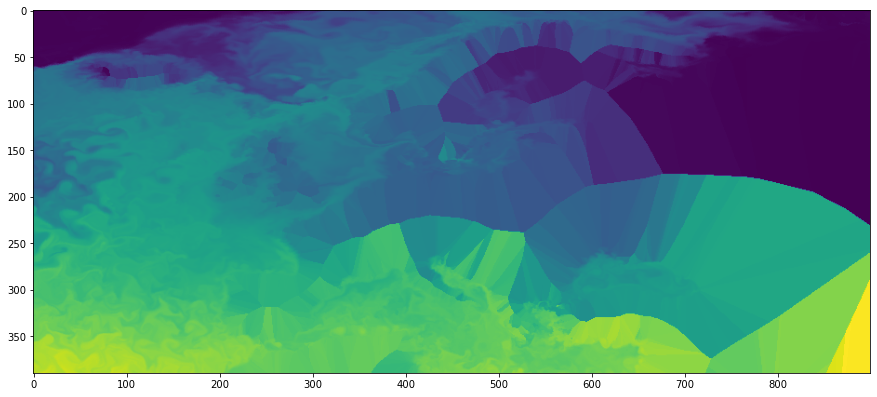

In [7]:
import matplotlib.pylab as plt
plt.figure(figsize=(15,15))
plt.imshow(np.flipud(interpolated_nn))

## masking land

In [8]:
def lon_lat_to_cartesian(lon, lat, R=6371000):
    """
    calculates lon, lat coordinates of a point on a sphere with
    radius R. Taken from http://earthpy.org/interpolation_between_grids_with_ckdtree.html
    """
    lon_r = np.radians(lon)
    lat_r = np.radians(lat)

    x = R * np.cos(lat_r) * np.cos(lon_r)
    y = R * np.cos(lat_r) * np.sin(lon_r)
    z = R * np.sin(lat_r)
    return x, y, z

def create_indexes_and_distances(model_lon, model_lat, lons, lats, k=1, workers=2):
    """
    Creates KDTree object and query it for indexes of points in FESOM mesh that are close to the
    points of the target grid. Also return distances of the original points to target points.
    Parameters
    ----------
    mesh : fesom_mesh object
        pyfesom mesh representation
    lons/lats : array
        2d arrays with target grid values.
    k : int
        k-th nearest neighbors to return.
    n_jobs : int, optional
        Number of jobs to schedule for parallel processing. If -1 is given
        all processors are used. Default: 1.
    Returns
    -------
    distances : array of floats
        The distances to the nearest neighbors.
    inds : ndarray of ints
        The locations of the neighbors in data.
    """
    xs, ys, zs = lon_lat_to_cartesian(model_lon, model_lat)
    xt, yt, zt = lon_lat_to_cartesian(lons.flatten(), lats.flatten())

    tree = cKDTree(list(zip(xs, ys, zs)))
    distances, inds = tree.query(list(zip(xt, yt, zt)), k=k, workers=workers)

    return distances, inds

In [9]:
from scipy.spatial import cKDTree

In [10]:
distances, inds = create_indexes_and_distances(model_lon_fesom, model_lat_fesom, lon2, lat2, k=1, workers=10)

In [11]:
radius_of_influence=5000
data_interpolated = data_sample.values[inds]
data_interpolated[distances >= radius_of_influence] = np.nan
data_interpolated = data_interpolated.reshape(lon2.shape)
data_interpolated = np.ma.masked_invalid(data_interpolated)

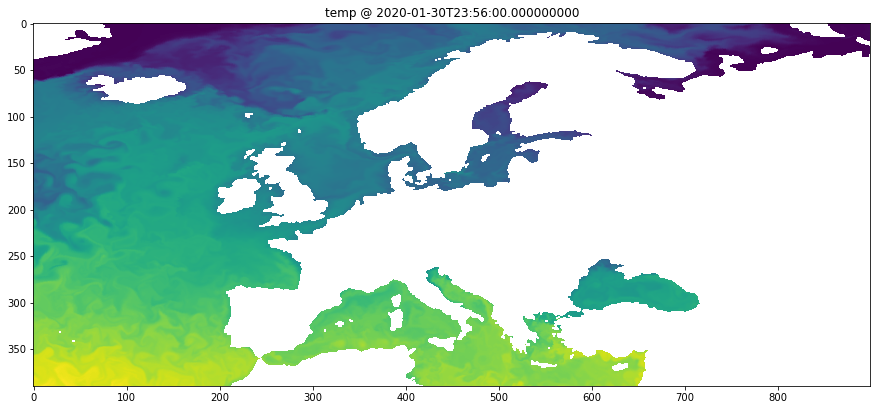

In [13]:
plt.figure(figsize=(15,15))
plt.imshow(np.flipud(data_interpolated))
plt.title(f"{data_sample.name} @ {data_sample.time.values}");